# Train your model

The first step is, of course, to install `great-ai` in your Python environment.

In [1]:
%pip install great-ai > /dev/null

Note: you may need to restart the kernel to use updated packages.


First, we have to get some data. After downloading it [from here](https://github.com/allenai/scibert/tree/master/data/text_classification/mag), we might notice that the dataset is in [JSON Lines](https://jsonlines.org/) format (each line is a seperate JSON document). 

Let's write a function which takes a single line, and returns the sentence and the corresponding label from it. Before returning, the sentence is also [cleaned](/reference/utilities/#great_ai.utilities.clean.clean) to remove any LaTeX, XML, unicode, PDF-extraction artifacts.

In [2]:
import json
from great_ai.utilities import clean


def preprocess(line):
    data_point = json.loads(line)

    sentence = data_point["text"]
    label = data_point["label"]

    return clean(sentence), label

Now, we can load the dataset and extract the *training* samples from it. Since we're impatient, we can do it in parallel using the [`simple_parallel_map`](/reference/utilities/#great_ai.utilities.simple_parallel_map) function.

> Open files in Python are iterable, with a line being return (in text mode) with each iteration.

In [3]:
from great_ai.utilities import simple_parallel_map

with open("data/train.txt", encoding="utf-8") as f:
    training_data = simple_parallel_map(preprocess, f)

X_train = [d[0] for d in training_data]
y_train = [d[1] for d in training_data]

100%|██████████| 84000/84000 [00:09<00:00, 8960.63it/s] 


Let's do the same for the *test* data.

In [4]:
with open("data/test.txt", encoding="utf-8") as f:
    test_data = simple_parallel_map(preprocess, f)

X_test = [d[0] for d in test_data]
y_test = [d[1] for d in test_data]

100%|██████████| 22399/22399 [00:03<00:00, 6078.02it/s]


After obtaining some clean data, it's time to create and train a model on it. We are going to use [scikit-learn](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) for this purpose.

In this case, we opted for a [linear Support Vector Machine](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) because it's known to be an adequate baseline for simple classification tasks.

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

model = make_pipeline(TfidfVectorizer(), LinearSVC())
# todo: hyperparameter-optimisation
model.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('linearsvc', LinearSVC())])

It's already finished. Let's see how well it performs. But first, we need to [configure matplotlib](https://matplotlib.org/stable/tutorials/introductory/customizing.html) to make the charts more legible. 
> `ConfusionMatrixDisplay` relies on `matplotlib` for rendering.

In [6]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (30, 15)
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = 12

Next, we check the quality of the model on the `test` split. We can use the classification report to check the common metrics, such as the macro F1-score. We also draw the confusion matrix to get some insights into the types of mistakes being made by the model.

              precision    recall  f1-score   support

    business       0.67      0.69      0.68      3198
   economics       0.69      0.71      0.70      3189
   geography       0.70      0.73      0.72      3207
    medicine       0.90      0.91      0.90      3187
    politics       0.63      0.57      0.60      3169
  psychology       0.73      0.73      0.73      3252
   sociology       0.51      0.51      0.51      3197

    accuracy                           0.69     22399
   macro avg       0.69      0.69      0.69     22399
weighted avg       0.69      0.69      0.69     22399



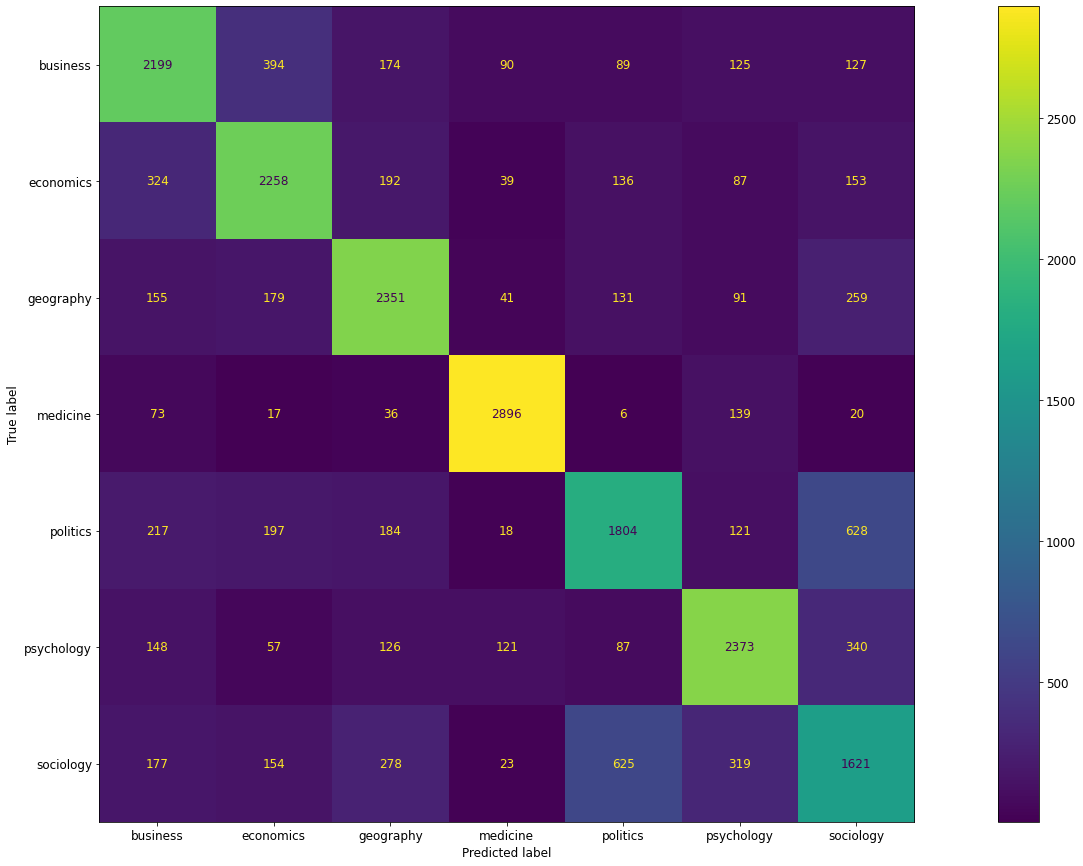

In [7]:
from sklearn import metrics

y_predicted = model.predict(X_test)

print(metrics.classification_report(y_test, y_predicted))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_predicted)
None

Great work, we can be rightfully satisfied with our model. Seeing the results, we achieved an F1-score of 0.69 which is about **5% better than SciBERT's** 0.6571!

You might wonder that *"this is great, but besides some utility functions (`clean`, `simple_parallel_map`, ...) what more value does GreatAI add?"*. This would be a valid argument because the scope of GreatAI actually only starts here.

> Not coincidentally, this is the point where the scope of Data Science ends but it's still a grey-zone for software engineering.

In order to use this model in production, we have to make it available on some possibly shared infrastructure.

In [8]:
from great_ai import save_model

save_model(model, key="my-domain-predictor")

Environment variable ENVIRONMENT is not set, defaulting to development mode ‼️
Cannot find credentials files, defaulting to using ParallelTinyDbDriver
The selected tracing database (ParallelTinyDbDriver) is not recommended for production
Cannot find credentials files, defaulting to using LargeFileLocal
GreatAI (v0.1.4): configured ✅
  🔩 tracing_database: ParallelTinyDbDriver
  🔩 large_file_implementation: LargeFileLocal
  🔩 is_production: False
  🔩 should_log_exception_stack: True
  🔩 prediction_cache_size: 512
  🔩 dashboard_table_size: 50
You still need to check whether you follow all best practices before trusting your deployment.
> Find out more at https://se-ml.github.io/practices
Fetching cached versions of my-domain-predictor
Copying file for my-domain-predictor-9
Compressing my-domain-predictor-9
Model my-domain-predictor uploaded with version 9


'my-domain-predictor:9'

### [Let's continue by finishing the deployment in the next notebook.](/tutorial/deploy)